# 3. Creating figures
The primary goal of this document is to generate, visualize, and analyze results derived from various machine learning models applied to our data. By the end of this exploration, we'll have a series of informative plots that can guide us in assessing the performance of these models.

### Structure:

1. Packages and Data: Initially, we will be loading essential packages and datasets that facilitate our exploration. These include common libraries like pandas, numpy, and matplotlib, as well as specific tools from sklearn.metrics and our custom utility ml_helper.

2. Results Table with Confidence Intervals: After loading the data, we will process the results from different models (both logistic regression and XGBoost, with varying feature sets). We'll then compute the confidence intervals for various metrics to gauge the robustness and consistency of our model's performance.

3. ROC AUC Curves: ROC (Receiver Operator Characteristic) curves are a cornerstone in evaluating classification model performances. We'll plot these for our models, allowing us to visually compare and understand the trade-off between sensitivity (True Positive Rate) and specificity (False Positive Rate) for different threshold values.

By the conclusion of this notebook, we'll have a comprehensive visual understanding of the performance of our machine learning models across different metrics and scenarios. Let's begin our exploration!

## 3.0. Packages and data

In [83]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import ml_helper as ml_help

## 3.1. Results table w/ confidence intervals

In [84]:
k_fold_results_directory = '../../results/k_fold_results/'

In [85]:
# Reupload
lr_ts_k_fold_results = pd.read_csv(k_fold_results_directory+'lr_all.csv')
lr_two_k_fold_results = pd.read_csv(k_fold_results_directory+'lr_two.csv')
xgb_ts_k_fold_results = pd.read_csv(k_fold_results_directory+'xgb_ts.csv')
xgb_two_k_fold_results = pd.read_csv(k_fold_results_directory+'xgb_two.csv')

In [86]:
# Define metrics to be calculated for the results table
metrics = ['roc_auc', 'brier', 'logloss', 'mae','accuracy',
           'balanced_accuracy', 'precision','recall',
           'f1', 'specificity']

In [87]:
xgb_two_k_fold_results.threshold.mean()

0.082

In [88]:
# Calculate confidence intervals for the simple model
simple_results = ml_help.calculate_confidence_intervals(lr_two_k_fold_results, metrics) #lr_two_k_fold_results
simple_results['model'] = 'LR Two Features'
# Calculate confidence intervals for the advanced model
complex_results = ml_help.calculate_confidence_intervals(lr_ts_k_fold_results, metrics)
complex_results['model'] = 'LR All features'

In [89]:
# Calculate confidence intervals for the simple model
simple_results_xgb = ml_help.calculate_confidence_intervals(xgb_two_k_fold_results, metrics) #lr_two_k_fold_results
simple_results_xgb['model'] = 'XGB Two Features'
# Calculate confidence intervals for the advanced model
complex_results_xgb = ml_help.calculate_confidence_intervals(xgb_ts_k_fold_results, metrics)
complex_results_xgb['model'] = 'XGB All Features'

In [90]:
# Combine results and pivot the table 
ci_results = simple_results.append(simple_results_xgb).append(complex_results).append(complex_results_xgb).pivot(columns=['model'], index='metric').T
# Save the results
ci_results.T.to_csv('../../results/mean_results/all_models_ci.csv')

In [91]:
ci_results[['roc_auc', 'balanced_accuracy', 'recall', 'specificity']]

metric                            roc_auc  balanced_accuracy  \
      model                                                    
value LR All features   0.87 (0.86, 0.88)  0.80 (0.78, 0.81)   
      LR Two Features   0.83 (0.81, 0.84)  0.76 (0.75, 0.77)   
      XGB All Features  0.89 (0.88, 0.90)  0.80 (0.80, 0.81)   
      XGB Two Features  0.85 (0.84, 0.86)  0.76 (0.75, 0.78)   

metric                             recall        specificity  
      model                                                   
value LR All features   0.77 (0.74, 0.81)  0.82 (0.79, 0.86)  
      LR Two Features   0.75 (0.72, 0.78)  0.76 (0.72, 0.80)  
      XGB All Features  0.83 (0.79, 0.87)  0.78 (0.74, 0.81)  
      XGB Two Features  0.78 (0.74, 0.82)  0.75 (0.70, 0.79)

## 3.2. ROC AUC curves

In [92]:
# Load full-featured xgb results
with open("../../results/dict_results/xgb_ts", "rb") as fp:   
    #Unpickling 
    xgb_results_ts = pickle.load(fp)

# Extract the observed and predicted probabilities 
xgb_ts_observed = xgb_results_ts['observed']
xgb_ts_predicted_probas = xgb_results_ts['probas']

# Load two-featured xgb results
with open("../../results/dict_results/xgb_results_two", "rb") as fp:   
    #Unpickling 
    xgb_results_two = pickle.load(fp)

# Extract the observed and predicted probabilities 
xgb_two_observed = xgb_results_two['observed']
xgb_two_predicted_probas = xgb_results_two['probas']

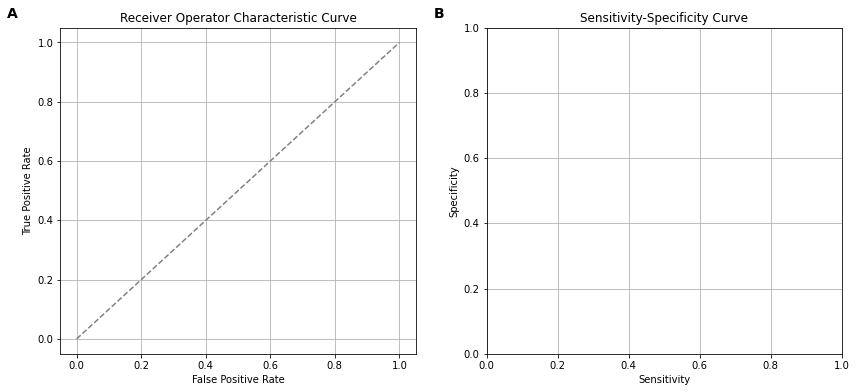

In [93]:
# Set up figure with two subplots
fig, ax = plt.subplots(1,2,figsize=(14,6))

# ROC AUC curve
ax[0].plot([0, 1], [0, 1], color='grey', linestyle='--')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operator Characteristic Curve')
ax[0].text(-0.15, 1.02, 'A', transform=ax[0].transAxes, fontweight="bold", va="bottom", ha="left", fontsize=14)
ax[0].grid(True)

# Sensitivity-specificity curve
ax[1].set_xlabel('Sensitivity')
ax[1].set_ylabel('Specificity')
ax[1].set_title('Sensitivity-Specificity Curve')
ax[1].text(-0.15, 1.02, 'B', transform=ax[1].transAxes, fontweight="bold", va="bottom", ha="left", fontsize=14)
ax[1].grid(True)


In [94]:
# Add the roc curve
ax[0] = ml_help.k_fold_threshold_curves(ax[0], xgb_ts_observed, xgb_ts_predicted_probas, 'orange','-', 'All features')
ax[0] = ml_help.k_fold_threshold_curves(ax[0], xgb_two_observed, xgb_two_predicted_probas, 'purple','-',  'Two features')

# Add the sens-spec curve
ax[1] = ml_help.sens_spec_curve(ax[1], xgb_two_observed, xgb_two_predicted_probas, 'purple','-')
ax[1] = ml_help.sens_spec_curve(ax[1], xgb_ts_observed, xgb_ts_predicted_probas, 'orange','-')

# Add legend
fig.legend()

In [95]:
xgb_all_row = ci_results[['roc_auc', 'balanced_accuracy', 'recall', 'specificity']].iloc[2]
xgb_two_row = ci_results[['roc_auc', 'balanced_accuracy', 'recall', 'specificity']].iloc[3]

In [96]:
xgb_all_row

metric
roc_auc              0.89 (0.88, 0.90)
balanced_accuracy    0.80 (0.80, 0.81)
recall               0.83 (0.79, 0.87)
specificity          0.78 (0.74, 0.81)
Name: (value, XGB All Features), dtype: object

In [97]:
# Table data
cols = ['Model', 'ROC AUC (95% CI)', 'Balanced accuracy (95% CI)', 'Sensitivity (95% CI)', 'Specificity (95% CI)']
data = [
    ['Full-featured XGBoost', xgb_all_row[0], xgb_all_row[1], xgb_all_row[2], xgb_all_row[3]],
    ['Two-featured XGBoost', xgb_two_row[0], xgb_two_row[1], xgb_two_row[2], xgb_two_row[3]]
]

In [98]:
# Table data
cols = ['Model', 'ROC AUC (95% CI)', 'Balanced accuracy (95% CI)', 'Sensitivity (95% CI)', 'Specificity (95% CI)']
data = [
    ['Full-featured XGBoost', xgb_all_row[0], xgb_all_row[1], xgb_all_row[2], xgb_all_row[3]],
    ['Two-featured XGBoost', xgb_two_row[0], xgb_two_row[1], xgb_two_row[2], xgb_two_row[3]]
]

# Adjust the bottom of the figure to make space for the table
fig.subplots_adjust(bottom=0.2)

# Add the table at the bottom of the fig
table_ax = fig.add_axes([0.125, -0.15, 0.775, 0.25])  # Adjust these values to change table position and size
table_ax.axis('off')
table = table_ax.table(cellText=data, colLabels=cols, cellLoc = 'center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjusting the cell heights
cell_height = 0.25
for i, cell in enumerate(table._cells):
    table._cells[cell].set_height(cell_height)

# Bold the header and the row labels
for (i, j), cell in table.get_celld().items():
    if i == 0 or j == 0:
        cell.set_text_props(fontweight='bold')

# Label for the table
table_ax.text(-0.05, 1, 'C', fontweight="bold", fontsize=14)

# Manually setting the borders
for i in range(len(cols)):
    table[0,i].visible_edges = 'B'  # header row
    table[0,i].visible_edges = 'T'  # 2nd row
    table[1,i].visible_edges = 'T'  # 3rd row
    table[2,i].visible_edges = 'B'  # bottom row


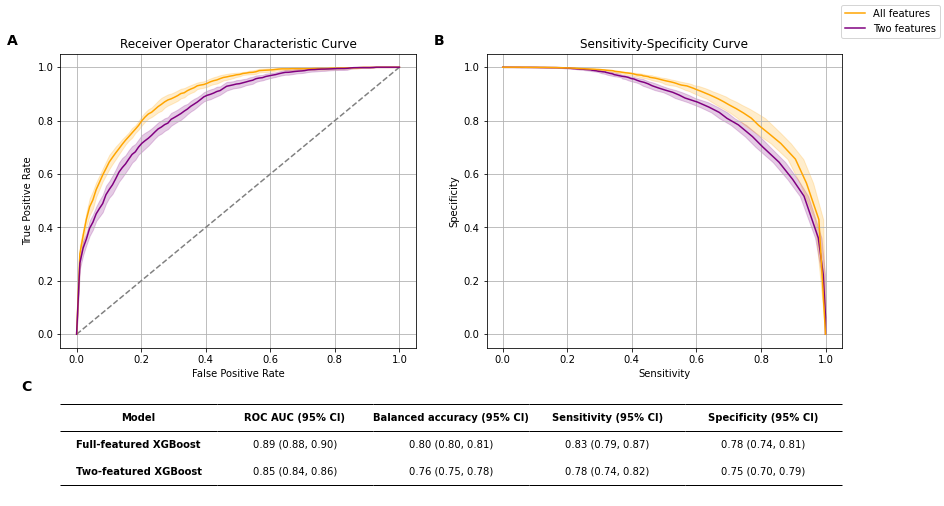

In [99]:
fig

### 3.2.1. ROC curve only

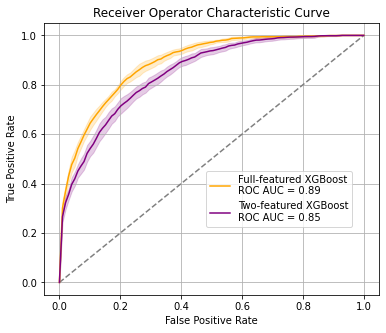

In [100]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operator Characteristic Curve')
ax.grid(True)

ax = ml_help.k_fold_threshold_curves(ax, xgb_ts_observed, xgb_ts_predicted_probas, 'orange','-', 'Full-featured XGBoost\nROC AUC = 0.89')
ax = ml_help.k_fold_threshold_curves(ax, xgb_two_observed, xgb_two_predicted_probas, 'purple','-',  'Two-featured XGBoost\nROC AUC = 0.85')
fig.legend(loc='lower right', bbox_to_anchor=(0.85, 0.3))


## Violinplot

In [101]:
# Upload dataset with predicted probabilities columns
df = pd.read_csv('../../results/probability_results/xgb.csv')

In [102]:
df.head()

,Unnamed: 0,intensity,day_of_week,time_of_day,duration,form_of_exercise,interval,study,bout_id,start_glc,...,glc__permutation_entropy__dimension_4__tau_1,glc__permutation_entropy__dimension_5__tau_1,glc__permutation_entropy__dimension_6__tau_1,glc__permutation_entropy__dimension_7__tau_1,glc__mean_n_absolute_max__number_of_maxima_7,stratify,probas_xgb_two,probas_xgb_two_fold,probas_xgb_ts,probas_xgb_ts_fold
0,0,0.0,1,afternoon,20.0,aer,5,dexip,dexip_100_20210610130600,6.56,...,1.214890,1.494175,1.747868,1.791759,7.675714,dexip_100_False,0.045296,3,0.009043,3
1,1,0.0,1,afternoon,15.0,aer,5,dexip,dexip_100_20213210153222,10.00,...,1.303092,1.386294,1.475076,1.560710,8.041429,dexip_100_False,0.320021,8,0.000658,8
2,2,0.0,1,evening,25.0,mix,5,dexip,dexip_100_20211110191100,6.61,...,1.002718,1.073543,1.153742,1.242453,6.325714,dexip_100_False,0.050906,2,0.001824,2
3,3,0.0,2,afternoon,15.0,aer,5,dexip,dexip_100_20215811125800,8.94,...,1.581094,1.906155,1.945910,1.791759,6.970000,dexip_100_False,0.013028,7,0.001020,7
4,4,0.0,2,afternoon,15.0,aer,5,dexip,dexip_100_20213511163500,7.22,...,1.427061,1.667462,1.747868,1.791759,6.254286,dexip_100_False,0.009517,0,0.003467,0


In [103]:
# Melt the dataframe
df_melted = df.melt(id_vars=['y'], value_vars=['probas_xgb_ts', 'probas_xgb_two'], 
                    var_name='Model', value_name='Predicted Probability')
# Rename the 'id' column to a new name, e.g., 'ID_new'
df_melted = df_melted.rename(columns={'y': 'Hypoglycemia'})

# 
df_melted['Model'] = df_melted['Model'].replace({'probas_xgb_ts':'Full-featured XGBoost', 'probas_xgb_two':'Two-featured XGBoost'})

In [104]:
df_melted

,Hypoglycemia,Model,Predicted Probability
0,False,Full-featured XGBoost,0.009043
1,False,Full-featured XGBoost,0.000658
2,False,Full-featured XGBoost,0.001824
3,False,Full-featured XGBoost,0.001020
4,False,Full-featured XGBoost,0.003467
...,...,...,...
32975,True,Two-featured XGBoost,0.348075
32976,False,Two-featured XGBoost,0.079371
32977,False,Two-featured XGBoost,0.334761
32978,True,Two-featured XGBoost,0.705002


In [105]:
import seaborn as sns 

plt.show()

In [106]:
# Load full-featured xgb results
with open("../../results/dict_results/xgb_ts", "rb") as fp:   
    #Unpickling 
    xgb_results_ts = pickle.load(fp)

# Extract the observed and predicted probabilities 
xgb_ts_observed = xgb_results_ts['observed']
xgb_ts_predicted_probas = xgb_results_ts['probas']

# Load two-featured xgb results
with open("../../results/dict_results/xgb_results_two", "rb") as fp:   
    #Unpickling 
    xgb_results_two = pickle.load(fp)

# Extract the observed and predicted probabilities 
xgb_two_observed = xgb_results_two['observed']
xgb_two_predicted_probas = xgb_results_two['probas']

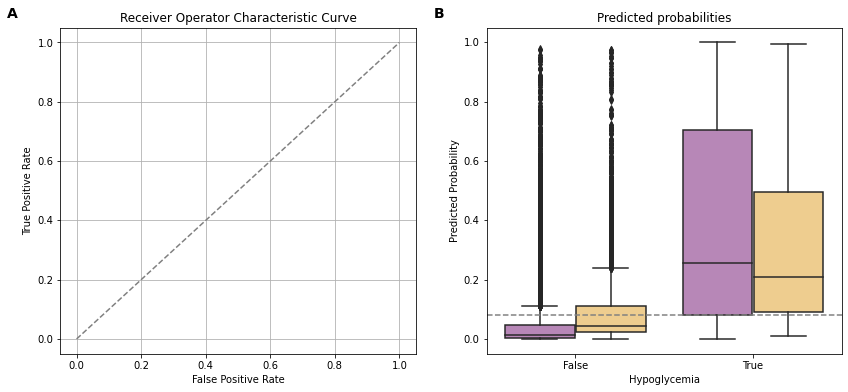

In [107]:
# Set up figure with two subplots
fig, ax = plt.subplots(1,2,figsize=(14,6))

# ROC AUC curve
ax[0].plot([0, 1], [0, 1], color='grey', linestyle='--')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operator Characteristic Curve')
ax[0].text(-0.15, 1.02, 'A', transform=ax[0].transAxes, fontweight="bold", va="bottom", ha="left", fontsize=14)
ax[0].grid(True)

# Add the sens-spec curve
ax[1] = sns.boxplot(hue=df_melted['Model'], y=df_melted['Predicted Probability'], x=df_melted['Hypoglycemia'], palette=['purple', 'orange'])
ax[1].text(-0.15, 1.02, 'B', transform=ax[1].transAxes, fontweight="bold", va="bottom", ha="left", fontsize=14)
ax[1].set_title('Predicted probabilities')
ax[1].axhline(y=xgb_two_k_fold_results.threshold.mean(), color='grey', linestyle='--', label='Mean Threshold')

# Adjust the alpha of the violins
for artist in ax[1].collections:
    artist.set_alpha(1)
# Remove the legend
ax[1].legend_.remove()
# Adjust the alpha of the boxes after the plot is created
for patch in ax[1].patches:
    color = patch.get_facecolor()
    patch.set_facecolor((color[0], color[1], color[2], 0.5))  # Set alpha to 0.8



In [108]:
# Add the roc curve
ax[0] = ml_help.k_fold_threshold_curves(ax[0], xgb_ts_observed, xgb_ts_predicted_probas, 'orange','-', '')
ax[0] = ml_help.k_fold_threshold_curves(ax[0], xgb_two_observed, xgb_two_predicted_probas, 'purple','-',  '')

# Add legend
fig.legend()

In [109]:
# Table data
cols = ['Model', 'ROC AUC (95% CI)', 'Balanced accuracy (95% CI)', 'Sensitivity (95% CI)', 'Specificity (95% CI)']
data = [
    ['Full-featured XGBoost', xgb_all_row[0], xgb_all_row[1], xgb_all_row[2], xgb_all_row[3]],
    ['Two-featured XGBoost', xgb_two_row[0], xgb_two_row[1], xgb_two_row[2], xgb_two_row[3]]
]

# Adjust the bottom of the figure to make space for the table
fig.subplots_adjust(bottom=0.2)

# Add the table at the bottom of the fig
table_ax = fig.add_axes([0.125, -0.15, 0.775, 0.25])  # Adjust these values to change table position and size
table_ax.axis('off')
table = table_ax.table(cellText=data, colLabels=cols, cellLoc = 'center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjusting the cell heights
cell_height = 0.25
for i, cell in enumerate(table._cells):
    table._cells[cell].set_height(cell_height)

# Bold the header and the row labels
for (i, j), cell in table.get_celld().items():
    if i == 0 or j == 0:
        cell.set_text_props(fontweight='bold')

# Label for the table
table_ax.text(-0.05, 1, 'C', fontweight="bold", fontsize=14)

# Manually setting the borders
for i in range(len(cols)):
    table[0,i].visible_edges = 'B'  # header row
    table[0,i].visible_edges = 'T'  # 2nd row
    table[1,i].visible_edges = 'T'  # 3rd row
    table[2,i].visible_edges = 'B'  # bottom row


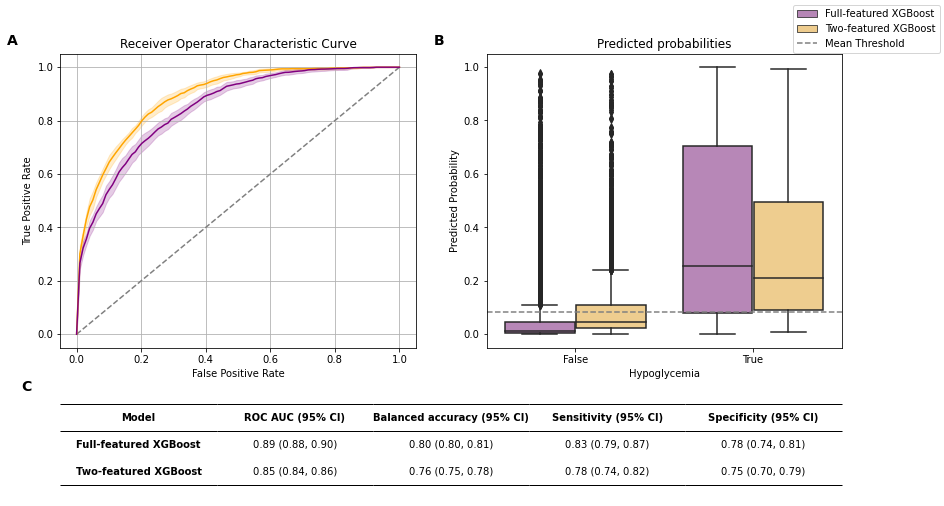

In [110]:
fig

In [111]:
fig.savefig('../../results/figs/fig_1.pdf', bbox_inches='tight')